# Facial Emotion Detection using Convolution Neural Network

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
import cv2
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torchvision
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torchmetrics import Accuracy 
%matplotlib inline
sns.set_style("whitegrid")

### Dataset Preperation

In [2]:
# importing the dataset
df = pd.read_csv("dataset/data.csv")
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [3]:
df.shape

(35887, 3)

In [4]:
df["Usage"].value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

In [5]:
df["emotion"].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [6]:
label_map = {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'sad', 5: 'surprise', 6: 'neutral'}

#### Since i don't want to have the suprise and disgust classes i am removing it

In [7]:
# removing the rows which are having the label as disgust and surprise
for idx, row in enumerate(df["emotion"]):
    if row == 1 or row == 5:
        df.drop(index=idx, axis=0, inplace=True)

In [8]:
df.shape

(31338, 3)

In [9]:
df["emotion"].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
Name: emotion, dtype: int64

In [10]:
df["emotion"] = df["emotion"].apply(lambda x: label_map[x])

In [11]:
df.head()

,emotion,pixels,Usage
0,angry,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,angry,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,fear,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,sad,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,neutral,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [12]:
df["emotion"].value_counts()

happy      8989
neutral    6198
sad        6077
fear       5121
angry      4953
Name: emotion, dtype: int64

In [13]:
final_label_map = {"angry": 0, "fear": 1, "happy":2, "sad": 3, "neutral": 4}

In [14]:
df["emotion"] = df["emotion"].apply(lambda x: final_label_map[x])

In [15]:
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,1,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,3,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,4,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [16]:
df.reset_index(drop=True, inplace=True)

In [17]:
df["emotion"][15]

2

In [18]:
def prepare_dataset(df):
    X = []
    y = []
    for i, pixels in enumerate(df["pixels"]):
        pixels = [int(pixel) for pixel in pixels.split()]
        X.append(pixels)
        y.append(df["emotion"][i])
    X, y = np.array(X)/255.0, np.array(y)
    return X, y

In [19]:
def split_data(df):
    train_df = df[df["Usage"] == "Training"]
    val_df = df[df["Usage"] == "PublicTest"]
    test_df = df[df["Usage"] == "PrivateTest"]
    
    train_df.drop("Usage", axis="columns", inplace=True)
    val_df.drop("Usage", axis="columns", inplace=True)
    test_df.drop("Usage", axis="columns", inplace=True)
    
    train_df.reset_index(drop=True, inplace=True)
    val_df.reset_index(drop=True, inplace=True)
    test_df.reset_index(drop=True, inplace=True)
    
    return train_df, val_df, test_df

In [20]:
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,1,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,3,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,4,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [21]:
train_df, val_df, test_df = split_data(df)
print(train_df.head())
print("Train df shape: ", train_df.shape)
print("Validation df shape: ", val_df.shape)
print("Test df shape", test_df.shape)

   emotion                                             pixels
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        0  151 150 147 155 148 133 111 140 170 174 182 15...
2        1  231 212 156 164 174 138 161 173 182 200 106 38...
3        3  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        4  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
Train df shape:  (25102, 2)
Validation df shape:  (3118, 2)
Test df shape (3118, 2)


E:\Anaconda\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [22]:
X_train, y_train = prepare_dataset(train_df)
X_val, y_val = prepare_dataset(val_df)
X_test, y_test = prepare_dataset(test_df)

In [23]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)

(25102, 2304)
(25102,)
(3118, 2304)
(3118,)
(3118, 2304)


#### Creating the pytorch dataset

In [24]:
class EmotionDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform
        self.length = len(X)
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, index):
        X = self.X[index].reshape(48, 48)
        X = Image.fromarray(X)
        y = self.y[index]
        
        if self.transform is not None:
            X = self.transform(X)
        return X, y

In [25]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
])

In [26]:
train_ds = EmotionDataset(X_train, y_train, transform=train_transform)
val_ds = EmotionDataset(X_val, y_val, transform=val_transform)
test_ds = EmotionDataset(X_test, y_test, transform=test_transform)

In [27]:
x, y = next(iter(train_ds))

E:\Anaconda\lib\site-packages\torchvision\transforms\functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))


In [28]:
x.shape

torch.Size([1, 48, 48])

In [29]:
batch_size = 32
num_epochs = 50

In [30]:
# Creating the data loader 
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=1)

In [31]:
def plot_from_dict(count_dict, title, **kwargs):
    df = pd.DataFrame.from_dict([count_dict]).melt()
    plt.barh(y = df["variable"], height=0.6, width=df["value"], color=["red", "orange", "green", "blue"])
    plt.xlabel("Counts")
    plt.ylabel("Classes")
    plt.xticks()
    plt.yticks()
    plt.title(title)

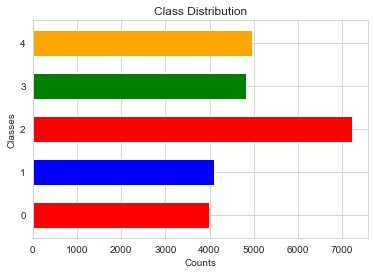

In [32]:
count_dict = train_df["emotion"].value_counts()
plot_from_dict(count_dict, "Class Distribution")

images.shape: torch.Size([32, 1, 48, 48])


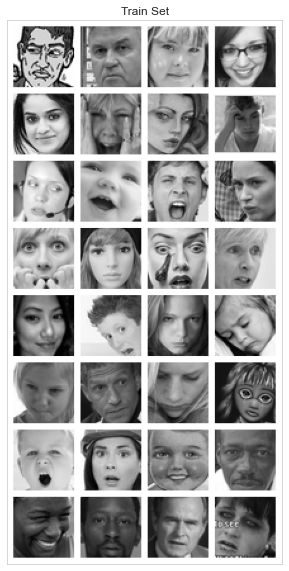

In [33]:
# plotting the sample images 
for x, y in val_loader:
    print('images.shape:', x.shape)
    plt.figure(figsize=(10,10))
    plt.xticks([]); plt.yticks([])
    plt.title('Train Set')
    plt.imshow(make_grid(x, nrow=4, padding=5, pad_value=1).permute(1,2,0))
    break

### Creating the model using the transfer learning approach

Creating the model using Resnet-152 architecture

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [35]:
from torchvision.models import resnet152
resnet_model = resnet152(pretrained=True).to(device)
resnet_model.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
num_features = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(in_features=num_features, out_features=5, bias=True)
resnet_model.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [36]:
# model = resnet_model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=0.002)

### Training using Resnet-152 Architecture

In [ ]:
print("Begin training.")
for epoch in range(num_epochs):
    train_metric = Accuracy().to(device)
    val_metric = Accuracy().to(device)
    train_epoch_loss = 0
    val_epoch_loss = 0
    
    # Training
    resnet_model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        y_train_pred = resnet_model(X_train_batch)#.squeeze()
        train_loss = criterion(y_train_pred, y_train_batch)
        acc = train_metric(y_train_pred, y_train_batch)
        train_loss.backward()
        optimizer.step()
        train_epoch_loss += train_loss.item()
    print(f'Epoch {epoch+1}:  | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Train Accuracy: {train_metric.compute().item():.4f}')
    
    # Validation
    resnet_model.eval()
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        output = resnet_model(x).to(device)
        acc = val_metric(output, y)
        loss = criterion(output, y)
        val_epoch_loss += loss.item()
    print(f'  Val Loss: {val_epoch_loss/len(val_loader):.4f} | Val Accuracy: {val_metric.compute().item():.4f}')

In [ ]:
torch.save(resnet_model, "model.pth")

In [37]:
### importing the model
model = torch.load("models/model.pth")

In [39]:
emotion_dict = {0: "angry", 1: "fear", 2:"happy", 3: "sad", 4: "neutral"}

In [40]:
import cv2
def detect_emotions(img_path, model):
    
    emotion_dict = {0: "angry", 1: "fear", 2:"happy", 3: "sad", 4: "neutral"}
    

    val_transform = transforms.Compose([
        transforms.ToTensor()])


    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    face_cascade = cv2.CascadeClassifier('./models/haarcascade_face.xml')
    faces = face_cascade.detectMultiScale(img)
    for (x, y, w, h) in faces:
        cv2.rectangle(img, (x,y), (x+w, y+h), (255,0,0), 2)
        resize_frame = cv2.resize(gray[y:y + h, x:x + w], (48, 48))
        X = resize_frame/256
        X = Image.fromarray((resize_frame))
        X = val_transform(X).unsqueeze(0)
        with torch.no_grad():
            model.eval()
            log_ps = model.cpu()(X)
            ps = torch.exp(log_ps)
            top_p, top_class = ps.topk(1, dim=1)
            pred = emotion_dict[int(top_class.numpy())]
        cv2.putText(img, pred, (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0,255), 2)
        print(pred)

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.grid(False)
    plt.axis('off')
    plt.show()


### Testing for Happy

happy


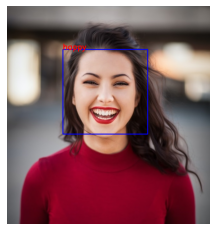

In [41]:
img_path = "F:/Data Science & AI/Tutorials/opencv/Photos/lady.jpg"
detect_emotions(img_path, model)

### Testing for fear

fear


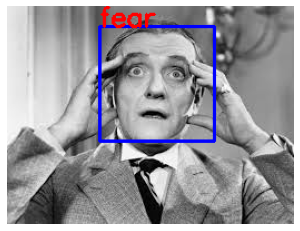

In [42]:
img2 = "C:/Users/Sudharsan Baskar/Desktop/fear.jfif"
detect_emotions(img2, model)

### Testing for Sad

sad


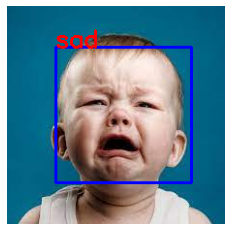

In [43]:
img3 = "C:/Users/Sudharsan Baskar/Desktop/sad.jfif"
detect_emotions(img3, model)

### Testing for Neutral

neutral


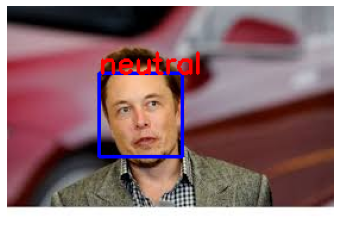

In [44]:
img4 = "C:/Users/Sudharsan Baskar/Desktop/neutral.jfif"
detect_emotions(img4, model)

### Testing on live webcam

In [ ]:
def detect_emotions_from_webcam(model):

#     model = load_trained_model('./models/FER_trained_model.pt')
    
    emotion_dict = {0: "angry", 1: "fear", 2:"happy", 3: "sad", 4: "neutral"}


    val_transform = transforms.Compose([
        transforms.ToTensor()])

    cap = cv2.VideoCapture(0)

    while True:
        ret, frame = cap.read()
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        face_cascade = cv2.CascadeClassifier('./models/haarcascade_face.xml')
        faces = face_cascade.detectMultiScale(frame)
        for (x, y, w, h) in faces:
            cv2.rectangle(frame, (x,y), (x+w, y+h), (255,0,0), 2)
            resize_frame = cv2.resize(gray[y:y + h, x:x + w], (48, 48))
            X = resize_frame/256
            X = Image.fromarray((X))
            X = val_transform(X).unsqueeze(0)
            with torch.no_grad():
                model.eval()
                log_ps = model.cpu()(X)
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                pred = emotion_dict[int(top_class.numpy())]
            cv2.putText(frame, pred, (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0,255), 3)
        
        cv2.imshow('frame', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

detect_emotions_from_webcam(model)